In [35]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Xk = np.random.uniform(-1,1,10000)
W= 3
hk = np.array([0.5 * (1 + np.cos(2 * np.pi / W * (k - 2))) if k in [1, 2, 3] else 0 for k in range(len(Xk))])
gaussain_noise = np.random.normal(0, np.sqrt(0.001), 10000)
yk = np.convolve(Xk, hk, mode='same') + gaussain_noise

cross entropy loss to be used as the loss function 
output slides
slide 33 
Linear adaptive equalizer 


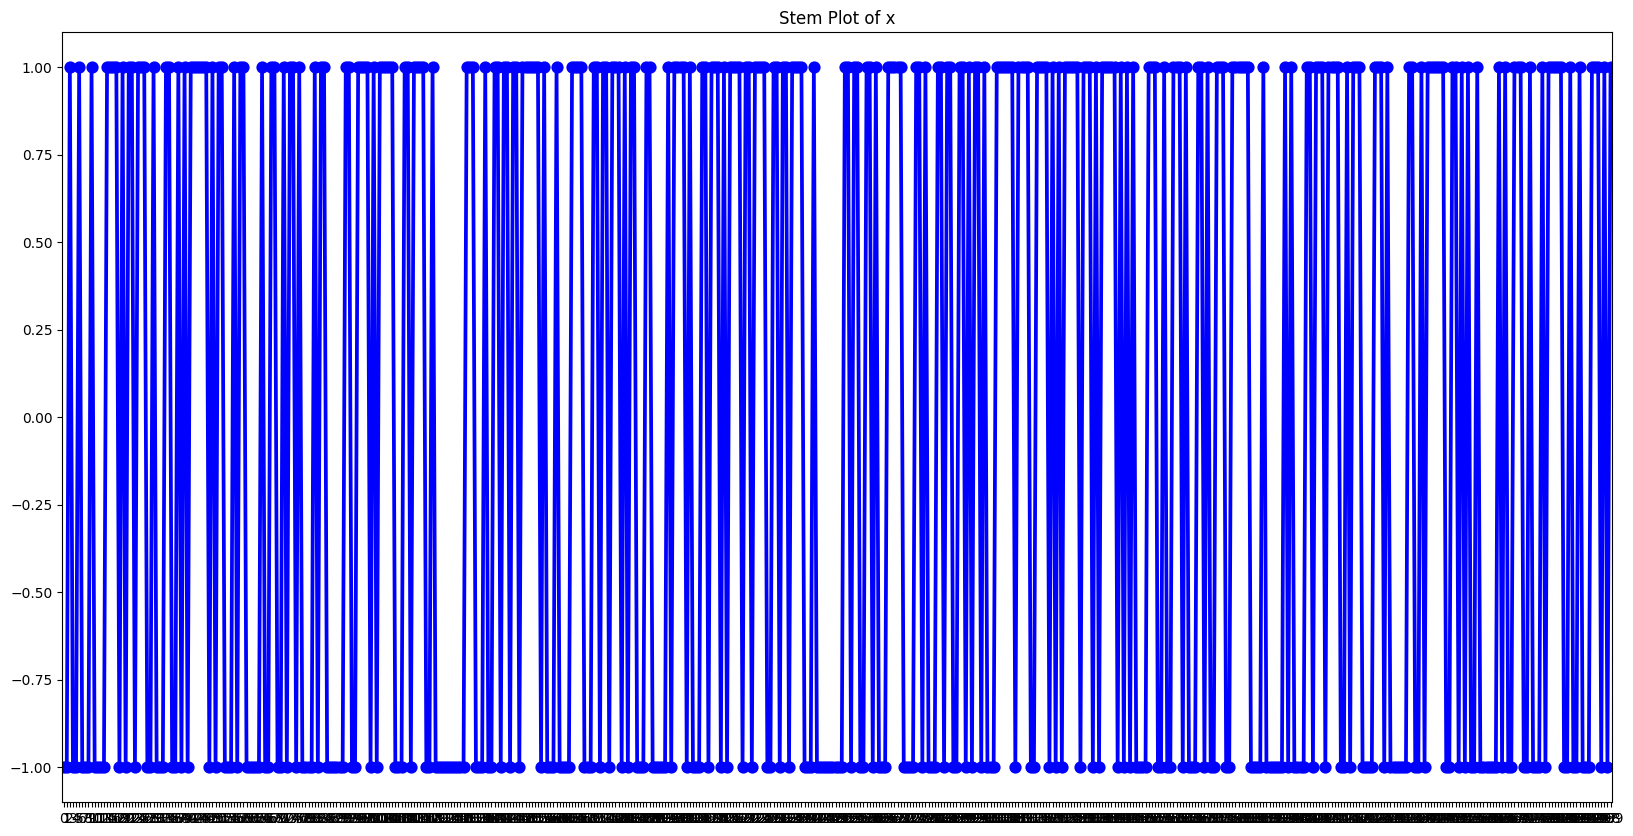

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
L = 10000
x = np.random.choice([1, -1], size=L)
plt.figure(figsize=(20, 10))
sns.pointplot(x[:500], color='blue')
plt.title('Stem Plot of x')
plt.show()

<AxesSubplot: >

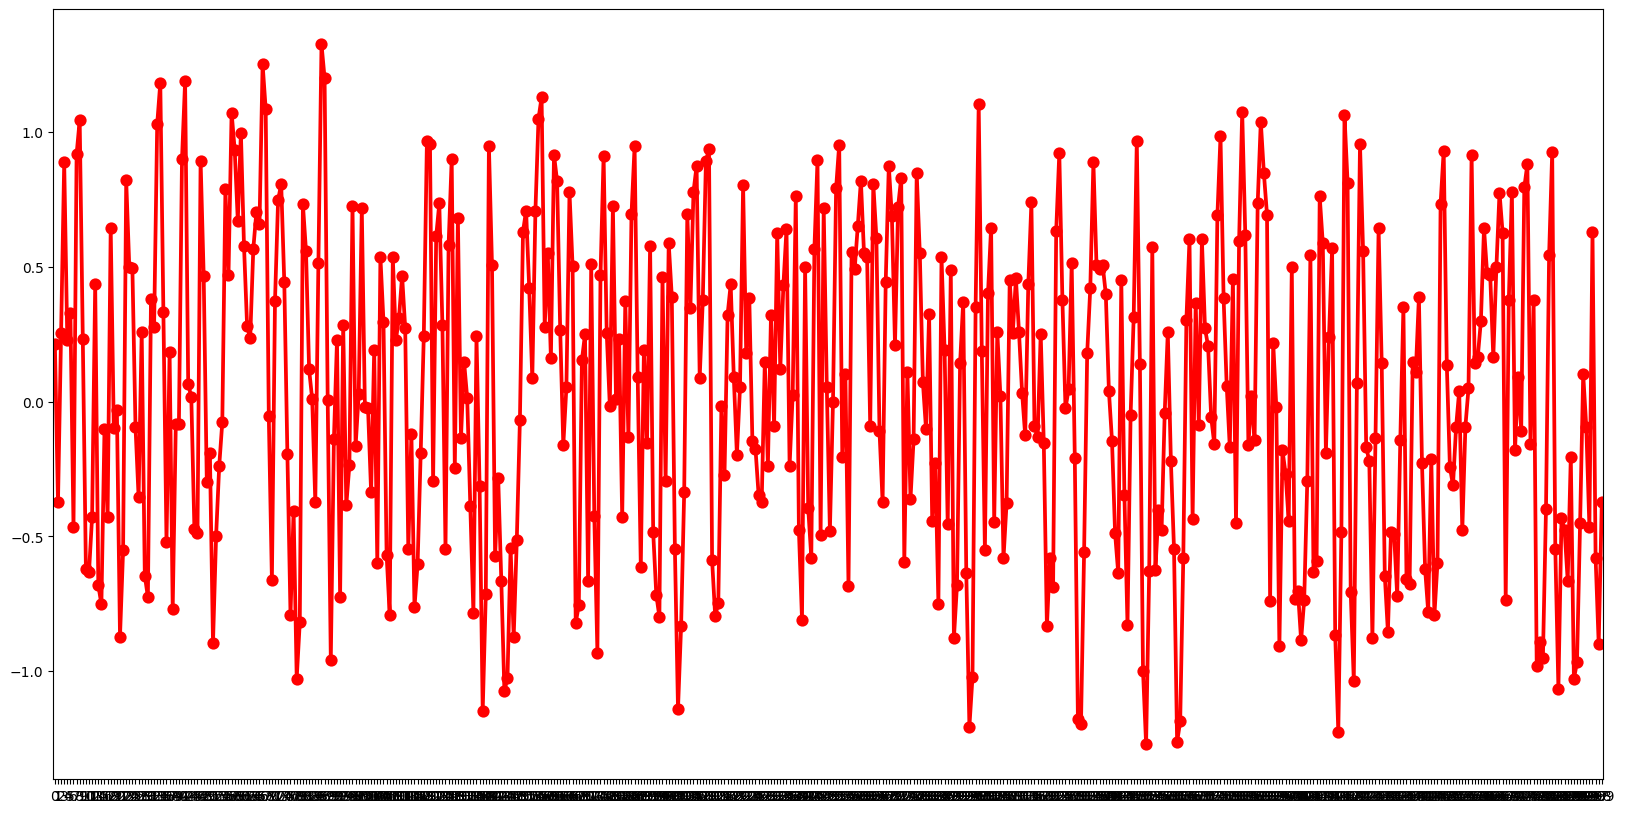

In [37]:
plt.figure(figsize=(20, 10))
sns.pointplot(yk[:500], color='red')

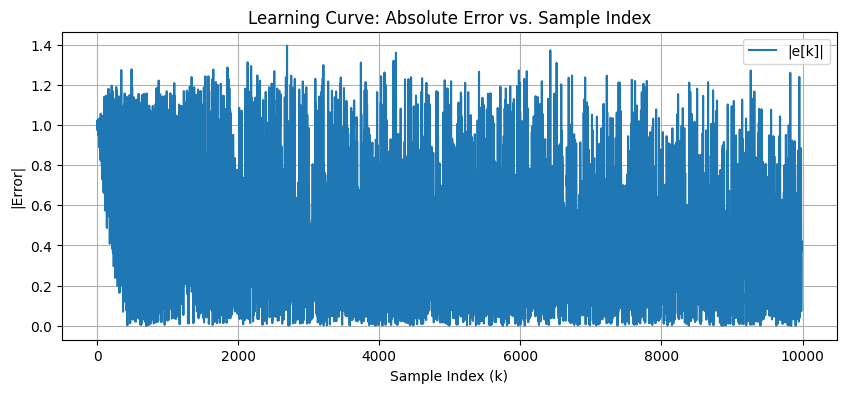

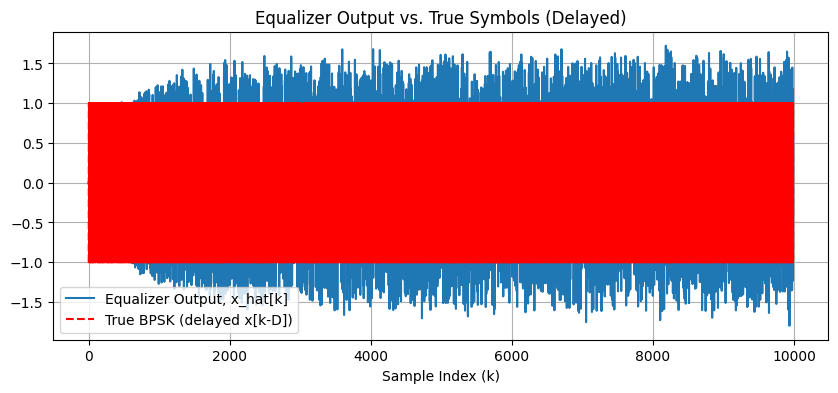

In [43]:
N = 2000         # Number of symbols
M = 11           # Number of equalizer taps
D = 3            # Decision delay
mu = 0.001  
# Example channel: h = [0.5, 1.0, 0.5] (length 3 FIR for demonstration)
h = np.array([0.5, 1.0, 0.5])

# Convolve transmit signal x with channel h
y_clean = np.convolve(x, h, mode='full')

# Add noise
noise_power = 0.01
noise = np.sqrt(noise_power) * np.random.randn(len(y_clean))
y = y_clean + noise
y
# Equalizer weights initialized to zero
w = np.zeros(M)
# Store the equalizer output and error for analysis
x_hat = np.zeros_like(y)  # We'll only really use valid indices
e = np.zeros_like(y)

# Main adaptation loop
for k in range(M + D, len(y)):
    # 1) Gather the last M samples of y (or zero if k-m < 0)
    y_tap_input = np.zeros(M)
    for m in range(M):
        if (k - m) >= 0:
            y_tap_input[m] = y[k - m]
    
    # 2) Equalizer output
    x_hat[k] = np.dot(w, y_tap_input)
    
    # 3) Compute error (we compare to x[k - D] if it's in range)
    if (k - D) < len(x) and (k - D) >= 0:
        e[k] = x_hat[k] - x[k - D]
    else:
        e[k] = 0.0
    
    # 4) Update weights (gradient descent rule)
    w = w - mu * e[k] * y_tap_input

# Trim the first M+D samples for a fair comparison
valid_start = M + D
x_hat_valid = x_hat[valid_start:len(x)]  # up to length of x
e_valid = e[valid_start:len(x)]

# Plot the learning curve (absolute error, for instance)
plt.figure(figsize=(10,4))
plt.plot(np.abs(e_valid), label="|e[k]|")
plt.title("Learning Curve: Absolute Error vs. Sample Index")
plt.xlabel("Sample Index (k)")
plt.ylabel("|Error|")
plt.grid(True)
plt.legend()
plt.show()

# Compare the final equalizer output to the desired (delayed) symbols
plt.figure(figsize=(10,4))
plt.plot(x_hat_valid, label="Equalizer Output, x_hat[k]")
plt.plot(x[valid_start - D:len(x) - D], 'r--', label="True BPSK (delayed x[k-D])")
plt.title("Equalizer Output vs. True Symbols (Delayed)")
plt.xlabel("Sample Index (k)")
plt.legend()
plt.grid(True)
plt.show()

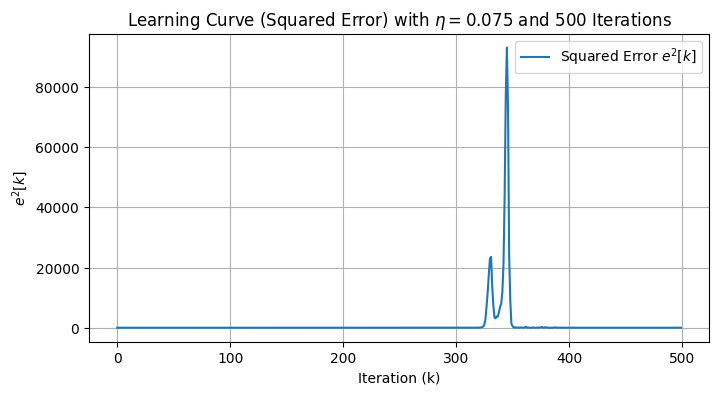

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1) Simulation Parameters
# -------------------------
N = 1000       # Number of symbols (for demonstration)
M = 11         # Number of equalizer taps
D = 3          # Decision delay
eta = 0.075    # Learning rate (step size)
max_iters = 500  # Limit our updates to 500

# Generate random BPSK symbols: x in {+1, -1}
np.random.seed(0)
x = np.random.choice([+1, -1], size=N)

# -------------------------
# 2) Simple Channel Model
# -------------------------
# Let's define a simple 3-tap channel for demonstration
h = np.array([0.5, 1.0, 0.5])
y_clean = np.convolve(x, h, mode='full')

# Add noise
noise_power = 0.01
noise = np.sqrt(noise_power) * np.random.randn(len(y_clean))
y = y_clean + noise

# -------------------------
# 3) Initialize Equalizer
# -------------------------
w = np.zeros(M)          # Filter weights (initially zero)
e = np.zeros(max_iters)  # We'll store only the first 500 errors
x_hat = np.zeros(max_iters)

# -------------------------
# 4) Adaptive LMS Loop
# -------------------------
# We'll only do 'max_iters' updates, even though y may be longer
for k in range(max_iters):
    
    # Form the M-length input vector for the filter
    # y[k], y[k-1], ..., y[k-(M-1)] 
    # If k-m < 0, we use 0 as a placeholder
    y_vec = np.zeros(M)
    for m in range(M):
        idx = (k - m)
        if idx >= 0 and idx < len(y):
            y_vec[m] = y[idx]
    
    # Equalizer output
    x_hat[k] = np.dot(w, y_vec)
    
    # Desired symbol is x[k - D], if in range
    if (k - D) >= 0 and (k - D) < len(x):
        desired = x[k - D]
    else:
        desired = 0  # or skip adaptation if out of bounds
    
    # Error
    err = x_hat[k] - desired
    
    # Update weights (LMS rule)
    w = w - eta * err * y_vec
    
    # Store error
    e[k] = err**2  # store squared error

# -------------------------
# 5) Plot e^2[k]
# -------------------------
plt.figure(figsize=(8,4))
plt.plot(e, label="Squared Error $e^2[k]$")
plt.title("Learning Curve (Squared Error) with $\eta = 0.075$ and 500 Iterations")
plt.xlabel("Iteration (k)")
plt.ylabel("$e^2[k]$")
plt.grid(True)
plt.legend()
plt.show()
